In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.core.pylabtools as pylabtools # for figsize
import seaborn as sns



def mask_data(data,*args):
    mask_and=np.array(args).all(0)
    return data[mask_and]

# Time series analysis: No external data

SURPRISINGLY dropping na values gives r-square around .69 but including drops is to .59

## Load and explore data

In [110]:
data=pd.read_csv("processed_data.csv")
#data.dropna(inplace=True)
data['date']=pd.to_datetime(data.date)

# convert categorical data to numerically labelled categories
# this would suffice for tree based models but for SVM and regression we will have to one-hot encode

#for col_name,col_data in data.iteritems():
#    if col_data.dtype == 'O':
#        data[col_name],tmp_indexer=pd.factorize(data[col_name])

In [111]:
data['delta_date']=(data.date-data.date[0])
data['delta_date']=map(lambda x : x.days,data.delta_date)

In [112]:
# For a time series analysis we cannot use other variables not related to date (we could include time and make the 
# intervals in hours instead of day but ultimatel the only fundamental information). Of course we can later add variables
# like the weather that are functions of the date

# If we want to analyze locations  (u'SECT_GEO_PEC', u'SECT_GEO_2_PEC') for instance we will have to do individual time series
# If we suspect cross correlations (and I don't) we could then look for those.

columns_to_use=['date','month','day','delta_date'] 
nd=pd.DataFrame({'total' : data.groupby( columns_to_use).size()}).reset_index()

In [113]:
# this chunk of code is important in case some delta_date values are missing, 
# this happens if we drop uncomment data.dropna(inplace=True) above

nd=nd.set_index('delta_date')
nd.index.max()

nd=nd.reindex(range(nd.index.max()+1)) 

start_date=nd.iloc[0].date

for index in nd[pd.isnull(nd.date)].index:
    nd.loc[index,'date']=start_date+pd.Timedelta(days=index)
    nd.loc[index,'month']=nd.loc[index,'date'].month
    nd.loc[index,'day']=pd.datetime.weekday(nd.loc[index,'date'])


nd.loc[nd.total.isnull(),'total']=int(nd.total.mean()) # should have a better way to impute

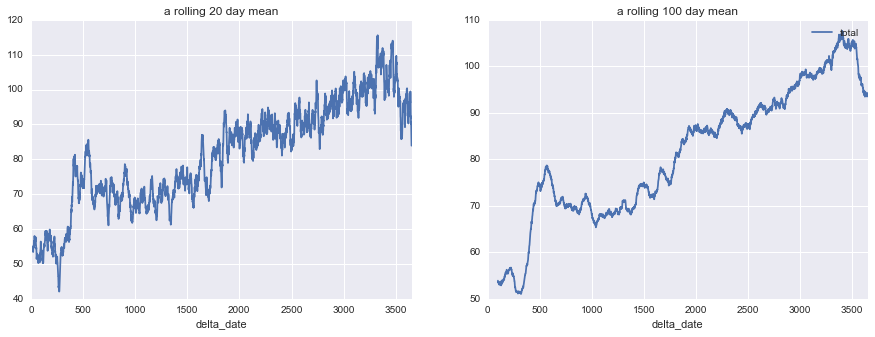

In [117]:
pylabtools.figsize(15,5)
plt.subplot(121)
plt.title("a rolling 20 day mean")
pd.rolling_mean(nd.total,20).plot()
plt.subplot(122)
plt.title("a rolling 100 day mean")
pd.rolling_mean(nd.total,100).plot()
plt.legend()

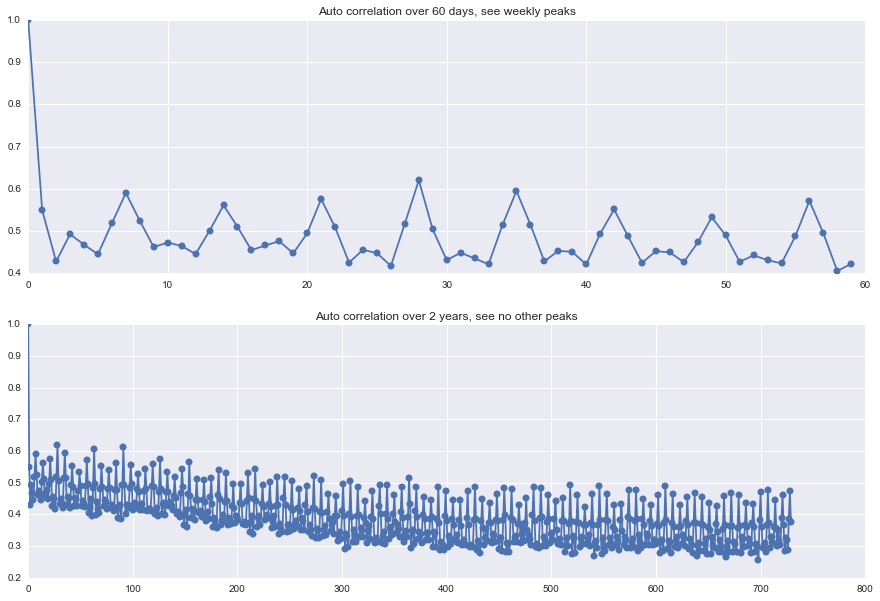

In [119]:
pylabtools.figsize(15,10)
plt.subplot(211)
autocorrelations=pd.Series([nd.total.autocorr(lag=l) for l in range(60)])
plt.plot(pd.rolling_mean(autocorrelations,1),"-o")
plt.title("Auto correlation over 60 days, see weekly peaks")

plt.subplot(212)
autocorrelations=pd.Series([nd.total.autocorr(lag=l) for l in range(2*365)])
plt.plot(pd.rolling_mean(autocorrelations,1),"-o")

plt.title("Auto correlation over 2 years, see no other peaks")

## Use Machine Learning to predict

In [121]:
# For machine learning treat delta_date as an independnet column instead of index
nd=nd.reset_index()

In [123]:
nd.head()

,delta_date,date,month,day,total
0,0,2004-01-01,1,3,72
1,1,2004-01-02,1,4,52
2,2,2004-01-03,1,5,46
3,3,2004-01-04,1,6,44
4,4,2004-01-05,1,0,48


In [203]:
# We will clearly use 'delta_date', 'month' and 'day' as independent variables to predict total but we also add the value 
# of total for the last 'total_lag_days' number of days as independent variables. 
# Based on the correlation analysis above we expect not more than a few days to matter. The weekly peak that seems
# to extend ad infinitum should be captured by 'day'

total_lag_days=15
for i in range(1,total_lag_days+1):
    nd['lag'+str(i)]=nd.total.shift(i)

cols=['lag'+str(i) for i in range(1,total_lag_days+1) ]

In [81]:
# We cant use the first 'total_lag_days' as they do not have complete information accroding to the above model
nd_final=nd[total_lag_days:]

In [82]:
# store the target 'total' values
y=nd_final.total.values

In [125]:
# we separate out the numerical variables from categorical ones as the categorical ones have to be one-hot-encoded

X_numerical=nd_final[cols].values
X_categorical=nd_final[['day','month']].values

In [126]:
# one hot encode the categorical variables

from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
enc.fit(X_categorical)
X_categorical=enc.transform(X_categorical).toarray()

In [127]:
# combine the numerical and categorical back into one 'X'
X=np.hstack((X_numerical,X_categorical))

In [189]:
# split the data into train and test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [190]:
# train the model on one of the tree regressors
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
clf=ExtraTreesRegressor(n_estimators=1000,n_jobs=-1)
clf.fit(X_train,y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=1000, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [191]:
# precict using the model on the test data set
y_pred=clf.predict(X_test)
y_pred=np.floor(y_pred+1) #make integer and err on side of caution

In [192]:
# compute the r-square value
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.59480070114936745

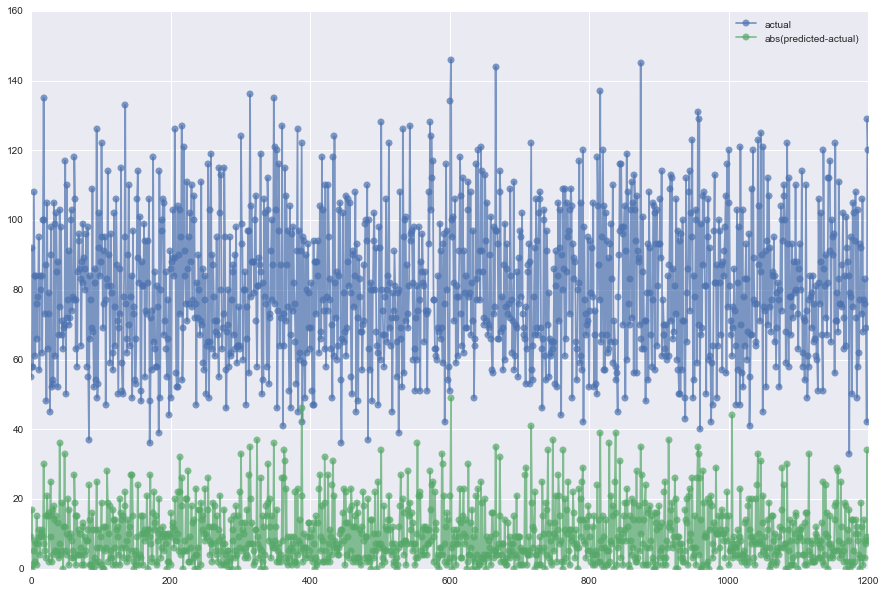

In [193]:
# the r-square value is just one measure of the accuracy
# here we plot the actual values and the difference of the prediction from the actual values

plt.plot(y_test,"-o",alpha=.7,label="actual")
plt.plot(np.abs(y_pred-y_test),"-o",alpha=.7,label="abs(predicted-actual)")
plt.legend()

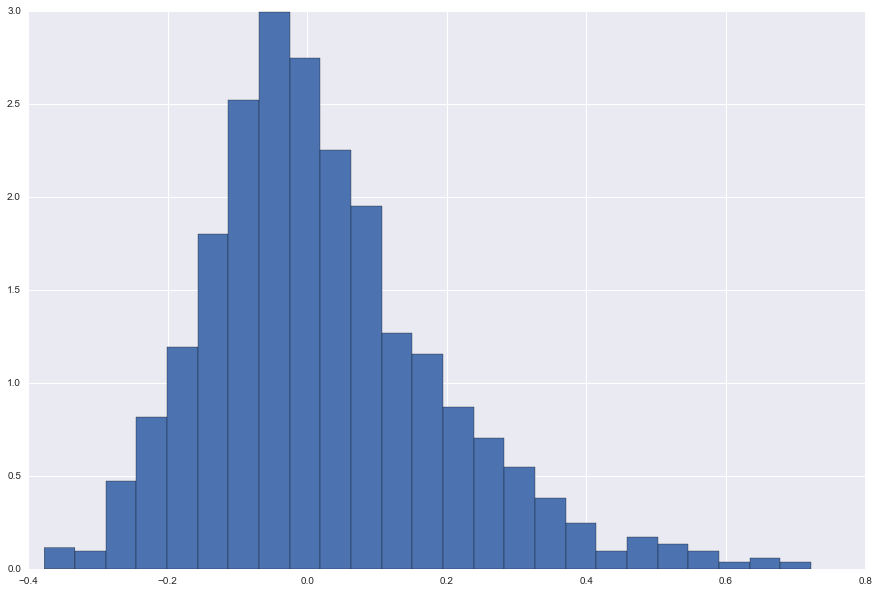

The mean of deviations is 0.022523 ± 0.004902


In [194]:
# further we can check the distribution of deviations

plt.hist((y_pred-y_test)/y_test,bins=25,normed=True)
plt.show()

deviations=(y_pred-y_test)/y_test

from scipy.stats import sem

print "The mean of deviations is %f ± %f" % (np.mean(deviations),sem(deviations))

# Effects of weather

In [195]:
# to use the weather data we have we will need the year as an explicit variable

nd['year']=map(lambda x: x.year,nd.date)

In [196]:
file=open('weather.csv')
data=[]
cols_from_weather_file=file.next().split() # the first line is the column names

In [197]:
# read in all the weather data
for l in file:
    data.append(l.split())

In [198]:
# convert to pandas dataframe and make the string variables into appropriate numerals
data_weather=pd.DataFrame(data,columns=cols_from_weather_file)
data_weather.Temperature=data_weather.Temperature.astype(float)
data_weather.Precipitation=data_weather.Precipitation.astype(float)
data_weather.Year=data_weather.Year.astype(int)
data_weather.Month=data_weather.Month.astype(int)


In [199]:
# merge the weather data into the above data
nd_with_weather=nd.merge(data_weather,left_on=['year','month'],right_on=['Year','Month'])

In [200]:
# again dump the first 'total_lag_days' days for the same reason as above
nd_final=nd_with_weather[total_lag_days:]

In [204]:
# add the temperatures and precipitation to list of numeric variables
cols_weather=cols+['Temperature', 'Precipitation']
cols_weather

['lag1',
 'lag2',
 'lag3',
 'lag4',
 'lag5',
 'lag6',
 'lag7',
 'lag8',
 'lag9',
 'lag10',
 'lag11',
 'lag12',
 'lag13',
 'lag14',
 'lag15',
 'Temperature',
 'Precipitation']

In [205]:
# repeat all steps as before

y=nd_final.total.values
X_numerical=nd_final[cols_weather].values
X_categorical=nd_final[['day','month']].values

enc=OneHotEncoder()
enc.fit(X_categorical)
X_categorical=enc.transform(X_categorical).toarray()

X=np.hstack((X_numerical,X_categorical))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [206]:
clf=ExtraTreesRegressor(n_estimators=1000,n_jobs=-1)
clf.fit(X_train,y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=1000, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [207]:
y_pred=clf.predict(X_test)

In [208]:
r2_score(y_test,y_pred)

0.59516257827406371

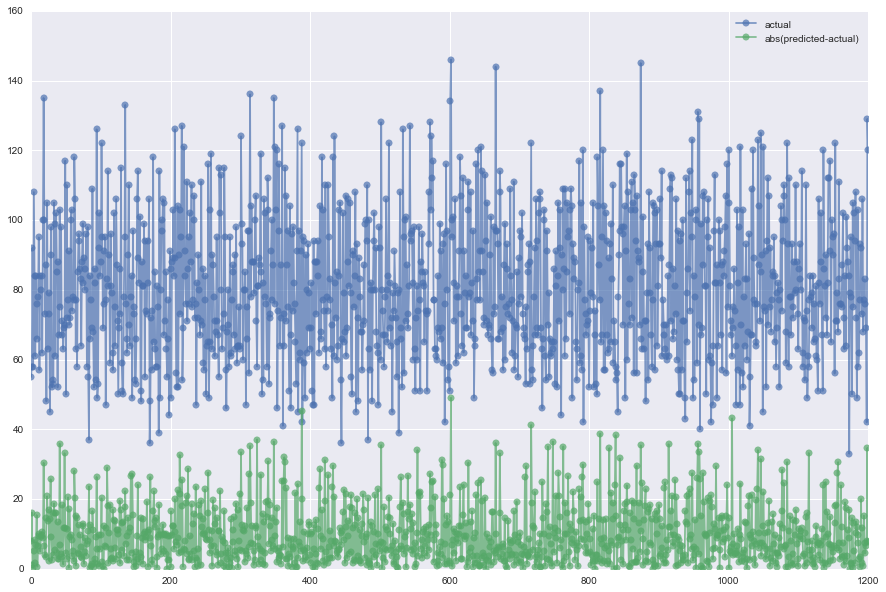

In [209]:
plt.plot(y_test,"-o",alpha=.7,label="actual")
plt.plot(np.abs(y_pred-y_test),"-o",alpha=.7,label="abs(predicted-actual)")
plt.legend()

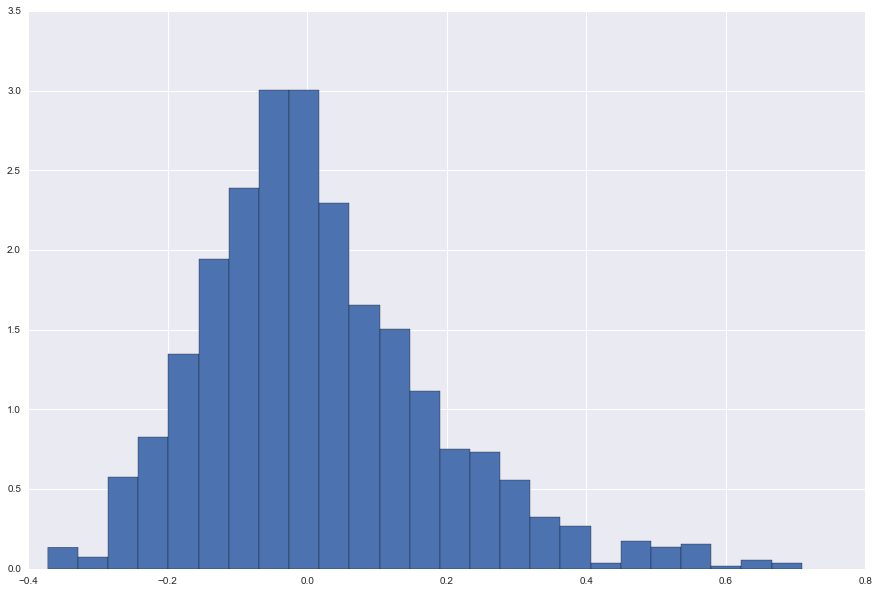

The mean of deviations is 0.016590 ± 0.004865


In [210]:
# further we can check the distribution of deviations

plt.hist((y_pred-y_test)/y_test,bins=25,normed=True)
plt.show()

deviations=(y_pred-y_test)/y_test

from scipy.stats import sem

print "The mean of deviations is %f ± %f" % (np.mean(deviations),sem(deviations))

# Conclusion

There seems to be a slight improvement when the weather data is included but its not obvious that it would stand up to cross validation.